# Stuart-Landau model with delay (SDDE) in NUMBA

In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
from vbi.models.numba.sl import SL_sde


Initializing Stuart-Landau model...
Stuart-Landau Oscillator Model (Numba)
Parameter        Explanation                                Value/Shape
--------------------------------------------------------------------------------
a                Bifurcation parameter          0.2
omega            Angular frequency (rad/ms)     0.25132741228718347
G                Global coupling strength       0.6
sigma            Noise amplitude                0.01
dt               Integration time step (ms)     0.01
t_end            Simulation end time (ms)       300.0
t_cut            Burn-in period (ms)            100.0
nn               Number of oscillators          4
seed             Random seed (-1 = no seed)     42
speed            Conduction velocity (mm/ms)    5.0
weights          Connectivity matrix (nn, nn)   shape (4, 4)
tr_len           Transmission distances (mm)    shape (4, 4)
initial_state    Initial complex states (nn,)   shape (4,)
RECORD_X         Record activity time series    True

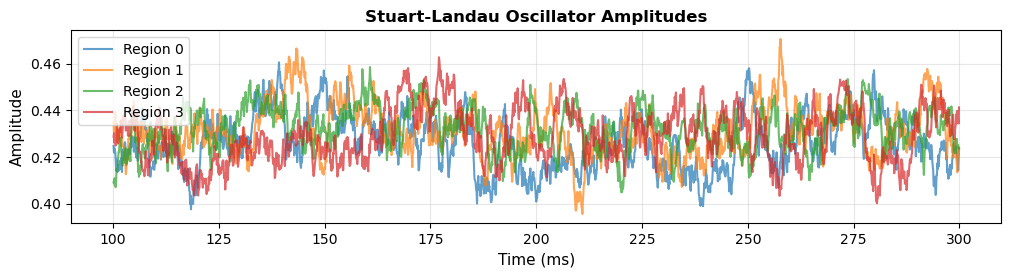

In [2]:
# Number of brain regions/nodes
nn = 4

# Create a simple connectivity matrix (undirected, symmetric)
# Adjust connection strengths to control coupling
weights = np.array(
    [
        [0.0, 0.15, 0.05, 0.0],
        [0.15, 0.0, 0.15, 0.05],
        [0.05, 0.15, 0.0, 0.15],
        [0.0, 0.05, 0.15, 0.0],
    ]
)

# Inter-regional distances (tr_len) can be:
# Option 1: Scalar - applied uniformly to all connected pairs
# tr_len = 10.0
#
# Option 2: Matrix (nn, nn) - specific distances for each pair
tr_len = np.array([
    [0.0, 10.0, 8.0, 0.0],
    [10.0, 0.0, 12.0, 9.0],
    [8.0, 12.0, 0.0, 11.0],
    [0.0, 9.0, 11.0, 0.0],
])

# Option 3: No delays
# tr_len = np.zeros_like(weights)  # No delays for simplicity

par = {
    "nn": nn,
    "weights": weights,
    "a": 0.20,  # Bifurcation parameter: 0.15-0.30 for oscillations
    "omega": 2.0
    * np.pi
    * 0.040,  # Angular frequency (rad/ms) = 2*pi*f_Hz/1000, here 40 Hz
    "G": 0.6,  # Coupling strength: 0.0 (uncoupled) to 1.0 (strong)
    "sigma": 0.01,  # Noise amplitude: 0.0 (deterministic) to 0.1 (noisy)
    "dt": 0.01,  # Timestep (ms): MUST be small (~0.01) for stability at high frequencies
    "t_end": 300.0,  # Total simulation time (ms)
    "t_cut": 100.0,  # Transient cutoff (ms): discard initial transients
    "speed": 5.0,  # Conduction velocity (mm/ms)
    "tr_len": tr_len,  # Typical inter-regional distance (mm)
    "seed": 42,  # Random seed: change for different realizations
    "RECORD_X": True,  # Record complex neural activity
    "x_decimate": 10,  # Decimation factor for X recording
}

# ============================================================================
# 2. Initialize and run simulation
# ============================================================================

print("Initializing Stuart-Landau model...")
model = SL_sde(par=par)
print(model)

print("Warming up ...")
tic = time.time()
result = model.run()
print(f"Warmup Simulation finished in {time.time()-tic:.2f} seconds.")

tic = time.time()
result = model.run()
print(f"Simulation finished in {time.time()-tic:.2f} seconds.")

# Extract results
t = result["t"]
X = result["X"]  # Complex neural activity: shape (time, nn)

print(f"Simulation completed!")
print(f"  Time points recorded: {len(t)}")
print(f"  Number of regions: {X.shape[1]}")

# ============================================================================
# 3. Analyze and visualize results
# ============================================================================

# Compute amplitude and phase from complex activity
amplitude = np.abs(X)  # Magnitude of oscillation
phase = np.angle(X)  # Phase of oscillation

print(f"\nActivity statistics:")
for i in range(nn):
    print(
        f"  Region {i}: amplitude mean={amplitude[:, i].mean():.4f}, "
        f"std={amplitude[:, i].std():.4f}"
    )

# Create visualization
fig, ax = plt.subplots(1, figsize=(12, 2.5))

# Plot 1: Amplitude over time

for i in range(nn):
    ax.plot(t, amplitude[:, i], label=f"Region {i}", alpha=0.7, linewidth=1.5)
ax.set_xlabel("Time (ms)", fontsize=11)
ax.set_ylabel("Amplitude", fontsize=11)
ax.set_title("Stuart-Landau Oscillator Amplitudes", fontsize=12, fontweight="bold")
ax.legend(loc="best")
ax.grid(True, alpha=0.3)

plt.show()